In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from ROOT import TVector3
import perform_calibrations as pc #import perform calibration package to get data
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ROOT
import array
import matplotlib
import uproot as ur
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('text', usetex=False)

In [7]:
t = pc.tpc_calibration()

In [8]:
recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0)

# Semi-loose x-ray veto
#### Use uncorrected energies for this, as x-rays may blend into recoil bands after correcting

In [ ]:
### PERFORM CUTS
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    recoils[tpc] = recoils[tpc].loc[recoils[tpc]['track_energy']>6] #initial x-ray veto
    recoils[tpc].index = [i for i in range(0,len(recoils[tpc]))] #reindex
    # TPC QUADRATIC CUTS
    
    y = np.array([6,20,800])
    if tpc == 'iiwi':
        x = np.array([1200, 1900, 15000])
    elif tpc == 'humu':
        x = np.array([1950, 3000, 20000])
    elif tpc == 'nene':
        x = np.array([950, 1900, 15000])
    elif tpc == 'tako':
        x = np.array([1000, 1900, 15000])
    elif tpc == 'palila':
        x = np.array([1000, 1750, 15000])
    else:
        x = np.array([1050, 2000, 15000])
    cut = np.polyfit(x,y,2)
    
    recoils[tpc] = recoils[tpc].loc[ #x-ray veto quadratic cut recoil
        recoils[tpc]['track_energy'] > cut[0]*recoils[tpc]['length']**2
        +cut[1]*recoils[tpc]['length']+cut[2]] #after this cut, only recoil bands remain

### Verify purity before cuts

<ipython-input-11-674f5ccafd00>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_under(color='white')


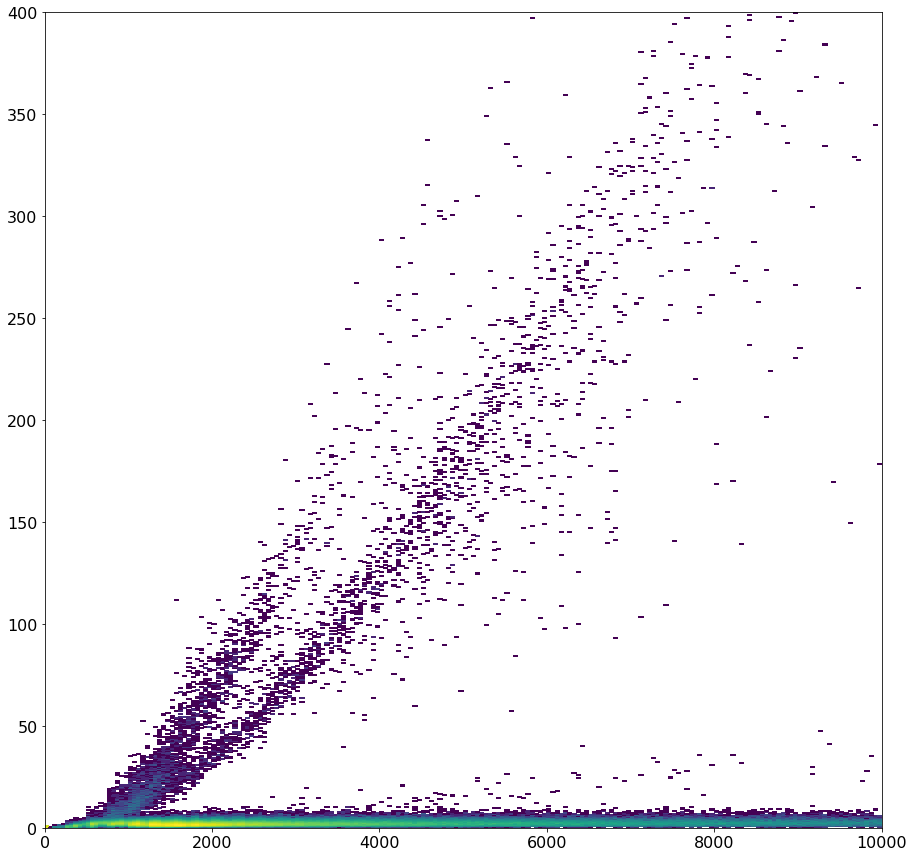

In [11]:
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
    
xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)

h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))

<ipython-input-118-9ec1e6357f02>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_under(color='white')
<ipython-input-118-9ec1e6357f02>:81: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [1433.0 1434.0 1435.0 ... 9998.0 9999.0 10000.0] in fill_betweenx(). This will become an error two minor releases later.
  ax0.fill_between(x_plt, 0, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], '-', color = 'red', lw=0, alpha = 0.1)
<ipython-input-118-9ec1e6357f02>:82: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [1433.0 1434.0 1435.0 ... 9998.0 9999.0 10000.0] in fill_betweenx(). This will become an error two minor releases later.
  ax0.fill_between(x_plt, cut[0]*x_plt*

<Figure size 1080x1080 with 0 Axes>

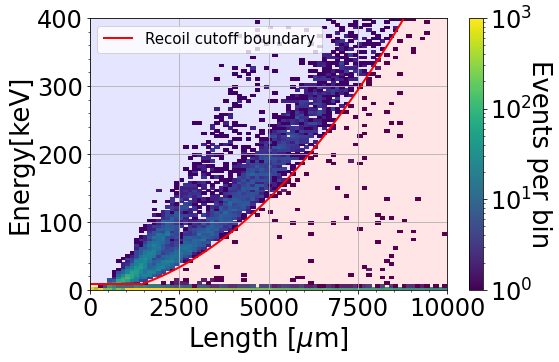

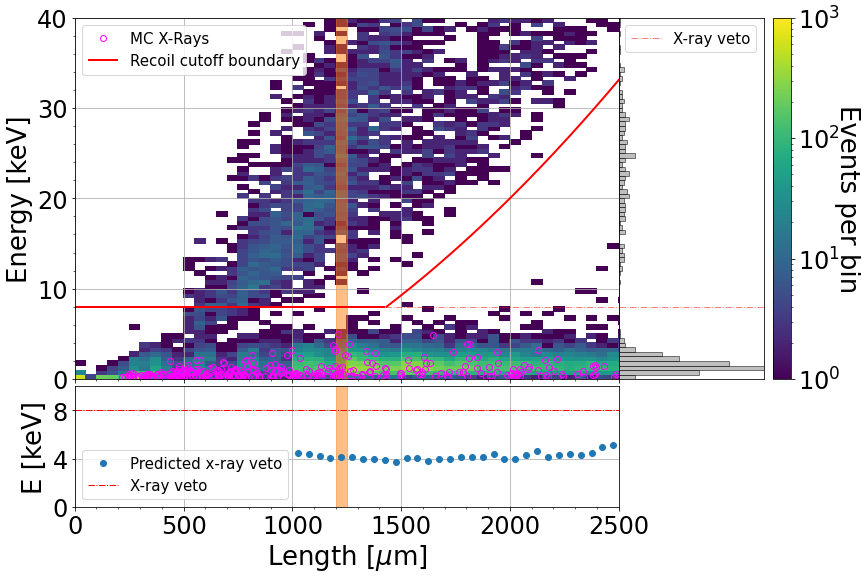

In [118]:
from scipy.stats import norm
fig = plt.figure(figsize = (15,15))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=15)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)
    
xm = 10000
ym = 400
nbinsx = int(xm/50)
nbinsy = int(ym*2)

bins = 0.5*(yedges[1:]+yedges[:-1])

h = {}
image = {}

veto = {}
length = {}
sigmas = {}
e_leak = {}

for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    veto[tpc] = []
    length[tpc] = []
    sigmas[tpc] = []
    e_leak[tpc] = []
    i=0
    for loc in range(20,51):
        low = bins[loc]*100-25
        high = bins[loc]*100+25
        x = np.array([2000, 2600, 5000])
        if tpc == 'iiwi':
            y_min = np.array([24, 42, 130])
            y_max = np.array([48, 80, 230])
        elif tpc == 'humu':
            y_min = np.array([10, 18, 64])
            y_max = np.array([48, 74, 214])
        elif tpc == 'nene':
            y_min = np.array([20, 36, 134])
            y_max = np.array([50, 84, 250])
        elif tpc == 'tako':
            y_min = np.array([24, 44, 164])
            y_max = np.array([60, 94, 280])
        elif tpc == 'palila':
            y_min = np.array([24, 44, 170])
            y_max = np.array([54, 90, 260])
        else:
            y_min = np.array([16, 32, 120])
            y_max = np.array([52, 94, 300])
    
        cut = np.polyfit(x,y_min,2)
        if loc >28:
            tmp = recoils[tpc].loc[(recoils[tpc]['length']>low) & (recoils[tpc]['length']<=high) & (recoils[tpc]['track_energy'] < cut[0]*recoils[tpc]['length']**2+cut[1]*recoils[tpc]['length']+cut[2])]
        else:
            tmp = recoils[tpc].loc[(recoils[tpc]['length']>low) & (recoils[tpc]['length']<=high) & (recoils[tpc]['track_energy'] < 8)]
        length[tpc].append(bins[loc]*100)
        veto[tpc].append(tmp['track_energy'].mean() + 3*tmp['track_energy'].std())
        sigmas[tpc].append(8-tmp['track_energy'].mean()/tmp['track_energy'].std())
        if loc > 28:
            e_leak[tpc].append((1-norm.cdf(sigmas[tpc][i]))*len(recoils[tpc].loc[(recoils[tpc]['track_energy'] < cut[0]*recoils[tpc]['length']**2+cut[1]*recoils[tpc]['length']+cut[2])]))
        i+=1

#def gauss(x,mu,sigma,A): # for gaussian fit
#    return A*exp(-(x-mu)**2/2/sigma**2)

fig, ax0 = plt.subplots(figsize=(8,5))
a,b,c,d = ax0.hist2d(recoils['nene']['length'], recoils['nene']['track_energy'], bins = (80,100), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
plt.colorbar(d).set_label('Events per bin', rotation = 270, labelpad = 20)
ax0.set_ylabel("Energy[keV]")
ax0.set_xlabel(r'Length [$\mu$m]')
ax0.yaxis.set_minor_locator(AutoMinorLocator())
ax0.xaxis.set_minor_locator(AutoMinorLocator())
x_plt = np.linspace(1433,10000,8568)
y_min = np.array([20, 36, 134])
cut = np.polyfit(x,y_min,2)
ax0.plot(x_plt, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], '-', color = 'red', lw=2)
ax0.fill_between(x_plt, 0, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], '-', color = 'red', lw=0, alpha = 0.1)
ax0.fill_between(x_plt, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], 400, '-', color = 'blue', lw=0, alpha = 0.1)
ax0.hlines(8,0,1427, color = 'red', lw=2, linestyle = '-', label = 'Recoil cutoff boundary')
ax0.fill_between(np.linspace(0,1433,1434), 0, 8, '-', color = 'red', lw=0, alpha = 0.1)
ax0.fill_between(np.linspace(0,1433,1434), 8, 400, '-', color = 'blue', lw=0, alpha = 0.1)
#ax0.hlines(8,1427,2500, color = 'red', lw=1, linestyle = '-.', alpha = 0.5)
plt.grid()
plt.legend()
plt.savefig('evl.jpg')

for tpc in ['nene']:#['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    for loc in range(24,25):
        fig, ax = plt.subplots(2,2, figsize = (13,9), gridspec_kw={'hspace': 0.03, 'wspace': 0, 'width_ratios': [3, 1], 'height_ratios': [3,1]})
        h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = ax[0,0].hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Events per bin', rotation = 270, labelpad = 20)
        bins = 0.5*(yedges[1:]+yedges[:-1])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xticklabels([])
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].hlines(8,0,1427, color = 'red', lw=2, linestyle = '-', label = 'Recoil cutoff boundary')
        ax[0,0].hlines(8,1427,2500, color = 'red', lw=1, linestyle = '-.', alpha = 0.5)
        ax[0,0].plot(df[tpc]['fit_length']*1e4, df[tpc]['reco_energy'], 'o', color = 'magenta', fillstyle = 'none', label = 'MC X-Rays')
        ax[0,0].set_ylim(0,40)
        ax[0,0].set_xlim(0,2500)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].set_xlabel(r'Length [$\mu$m]')
        ax[0,0].legend(loc = 'upper left')
        ax[0,0].grid(which='major')
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray',edgecolor = 'black')
        ax[0,1].hlines(8,0,h[tpc+'_uncor'][loc].max(), color = 'red', linestyle = '-.', lw=1, alpha =0.5, label = 'X-ray veto')
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].set_ylim(0,40)
        ax[0,1].set_xlim(0,h[tpc+'_uncor'][loc].max())
        ax[0,1].legend()
        ax[1,0].plot(length[tpc],veto[tpc], 'o', label = 'Predicted x-ray veto')
        ax[1,0].hlines(8,0,2550, linestyle = '-.', color = 'red', lw = 1, label = 'X-ray veto')
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_xlim(0,2500)
        ax[1,0].set_ylim(0,10)
        ax[1,0].set_yticks([0,4,8])
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel('E [keV]')
        ax[1,0].legend(loc='lower left')
        ax[1,0].grid(which = 'major')
        
        x = np.array([2000, 2600, 5000])
        if tpc == 'nene':
            x_plt = np.linspace(1433,2500,2501)
            y_min = np.array([20, 36, 134])
            y_max = np.array([50, 84, 250])
            cut = np.polyfit(x,y_min,2)
            ax[0,0].plot(x_plt, cut[0]*x_plt**2 + cut[1]*x_plt + cut[2], '-', color = 'red', lw=2)
            
        fig.delaxes(ax[1,1])
        plt.savefig('xray_veto_threshold.jpg')
        plt.show()


In [109]:
for tpc in e_leak.keys():
    print(tpc+': %s'%(max(e_leak[tpc])))

iiwi: 0.0004342935077201737
humu: 0.00015096591476382315
nene: 0.00010620152902962587
tako: 4.0000882857049724e-05
palila: 0.0004959377445494795
elepaio: 0.00010510664112839407


In [ ]:
plt.figure(figsize = (12,12))
i = 1
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila']:
    plt.subplot(3,2,i)
    plt.plot(length[tpc],veto[tpc], 'o')
    plt.hlines(8,1200,2350, color = 'red')
    plt.title(tpc)
    plt.xlabel('length bin center[um]')
    plt.ylabel(r'$\mu+3\sigma$ xray band')
    i+=1
    plt.ylim(0,10)
    plt.xlim(1200,2300)
plt.tight_layout()

### Add in MC electrons

In [5]:
def apply_energy_calibrations_to_MC(MC):
        gain = {'iiwi': 1502, 'nene': 899, 'humu': 878, 'palila': 1033, 'tako': 807, 'elepaio': 797}
        tpcs = ['iiwi', 'nene', 'humu', 'palila', 'tako', 'elepaio']
        W = 35.075
        tot_to_q = {}
        for tpc in tpcs:
            tot_to_q[tpc] = pd.DataFrame()
            tot_to_q[tpc]['tot_code'] = [i for i in range(0,14)]
            
        tot_to_q['iiwi']['conversion'] = np.array([1833.00, 2345.17, 3017.33, 6001.54, 8891.71,
                                  11497.43, 14335.32, 18081.33, 22526.06, 27236.90,
                                  32056.16, 36955.09, 41874.75, 46794.40])

        tot_to_q['nene']['conversion'] = np.array([2083.56, 2482.24, 4126.52, 5621.03, 7920.43,
                                                   11667.35, 15117.97, 19489.23, 23211.63, 27483.98,
                                                   32272.73, 37262.83, 42283.59, 47304.34])

        tot_to_q['humu']['conversion'] = np.array([2083.47, 2324.41, 3679.37, 5433.43, 6862.72,
                                                   10000.83, 13701.08, 17258.86, 21438.70, 25821.34,
                                                   30153.82, 34460.74, 39042.80, 43624.85])

        tot_to_q['palila']['conversion'] = np.array([1768.71, 2202.75, 2670.76, 4049.25, 6586.25,
                                    8954.45, 11551.60, 14428.46, 17618.81, 21140.34,
                                    24831.56, 28804.80, 33534.23, 40821.35])

        tot_to_q['tako']['conversion'] = np.array([2761.20, 3077.66, 3509.80, 5475.02, 9230.59, 
                                  11955.00, 16837.46, 20761.78, 24514.73, 28445.96, 
                                  33071.27, 38033.29, 43011.21, 47989.15])

        tot_to_q['elepaio']['conversion'] = np.array([1859.09, 2496.61, 4128.03, 6844.95, 9450.70,
                                     12158.68, 15125.31, 18507.89, 22166.14, 25826.40,
                                     29597.06, 33588.70, 38207.92, 42827.15])
        for tpc in tpcs:
            MC[tpc]['q_from_tot'] = MC[tpc]['tot']
            
            for i in range(0,len(MC[tpc])):
                try:
                    MC[tpc]['q_from_tot'].iloc[i] = pd.Series(MC[tpc]['tot'].iloc[i]).map(tot_to_q[tpc].set_index('tot_code')['conversion']).to_numpy()
                except ValueError:
                    print(tpc, i)
            MC[tpc]['sumtot'] = [MC[tpc]['q_from_tot'][i].sum() for i in range(0,len(MC[tpc]))]
            MC[tpc]['reco_energy'] = MC[tpc]['sumtot']*35.075/gain[tpc]*1e-3

        return MC

df = {}
tpcs = ['iiwi','nene','humu', 'palila', 'tako', 'elepaio']
for tpc in tpcs:
    f = ur.open('/home/jeef/data/phase3/spring_2020/05-09-20/geant4_simulation/electrons/%s.root'%(tpc))['tree_fe4_after_threshold']
    df[tpc] = f.pandas.df(flatten=False)
apply_energy_calibrations_to_MC(df)

{'iiwi':        event  npoints  fitok  \
 entry                          
 0          0        4      1   
 1          1        3      1   
 2          2       12      1   
 3          3        6      1   
 4          4        3      1   
 5          5        4      1   
 6          6       12      1   
 7          7       20      1   
 8          8       31      1   
 9          9        3      1   
 10        10       11      1   
 11        11        3      1   
 12        12       21      1   
 13        13        6      1   
 14        14       13      1   
 15        15       17      1   
 16        16        8      1   
 17        17       18      1   
 18        18        3      1   
 19        19       39      1   
 20        20       10      1   
 21        21        7      1   
 22        22       11      1   
 23        23        6      1   
 24        24        4      1   
 25        25       88      1   
 26        26       12      1   
 27        27       26      1   
 2

In [ ]:
plt.figure(figsize = (9,9))
i=1
for tpc in tpcs:
    plt.subplot(3,2,i)
    plt.plot(recoils[tpc]['length'], recoils[tpc]['track_energy'], 'o', markersize = 1, label = 'data')
    plt.plot(df[tpc]['fit_length']*1e4, df[tpc]['reco_energy'], 'o', label = 'MC')
    plt.hlines(8,0,2500,color = 'red')
    plt.ylim(0,40)
    plt.xlim(0,2500)
    plt.ylabel('Energy[keV]')
    plt.xlabel('length[um]')
    plt.title(tpc)
    plt.legend()
    i+=1
plt.tight_layout()
plt.show()

### Plot uncorrected and corrected recoil bands

In [ ]:
fig = plt.figure(figsize = (12,24))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
    
xm = 8000
ym = 400
nbinsx = int(xm/100)
nbinsy = int(ym/4)

h = {}
image = {}

i = 1
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    p = plt.subplot(6,2,i)
    p.xaxis.set_minor_locator(AutoMinorLocator())
    p.yaxis.set_minor_locator(AutoMinorLocator())
    h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.ylim(0,300)
    plt.xlim(0,5500)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Uncorrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    p = plt.subplot(6,2,i+1)
    p.xaxis.set_minor_locator(AutoMinorLocator())
    p.yaxis.set_minor_locator(AutoMinorLocator())
    h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.ylim(0,300)
    plt.xlim(0,5500)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Corrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    i += 2

plt.tight_layout()
plt.show()

### Plot He recoil band cuts to be used as training sample for double gaussian fitter

In [ ]:
fig = plt.figure(figsize = (12,24))
cmap = plt.cm.viridis
cmap.set_under(color='white')
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
    
xm = 10000
ym = 800
nbinsx = int(xm/100)
nbinsy = int(ym/4)

h = {}
image = {}

x_plt = np.linspace(0,xm,xm+1)

i = 1
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    
    #UNCORRECTED RECOILS
    plt.subplot(6,2,i)
    
    x = np.array([2000, 2600, 5000])
    if tpc == 'iiwi':
        y_min = np.array([24, 42, 130])
        y_max = np.array([48, 80, 230])
    elif tpc == 'humu':
        y_min = np.array([10, 18, 64])
        y_max = np.array([48, 74, 214])
    elif tpc == 'nene':
        y_min = np.array([20, 36, 134])
        y_max = np.array([50, 84, 250])
    elif tpc == 'tako':
        y_min = np.array([24, 44, 164])
        y_max = np.array([60, 94, 280])
    elif tpc == 'palila':
        y_min = np.array([24, 44, 170])
        y_max = np.array([54, 90, 260])
    else:
        y_min = np.array([16, 32, 120])
        y_max = np.array([52, 94, 300])
        
    cut_min = np.polyfit(x,y_min,2)
    cut_max = np.polyfit(x,y_max,2)
    #print(tpc, cut_min, cut_max)
    
    h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.fill_between(x_plt, cut_min[0]*x_plt**2 + cut_min[1]*x_plt + cut_min[2],
                    cut_max[0]*x_plt**2 + cut_max[1]*x_plt + cut_max[2], color = 'magenta', alpha = 0.3)
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Uncorrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    
    #CORRECTED RECOILS
    plt.subplot(6,2,i+1)
    
    if tpc == 'iiwi':
        y_min = np.array([26, 50, 190])
        y_max = np.array([58, 90, 280])
    elif tpc == 'humu':
        y_min = np.array([16, 24, 80])
        y_max = np.array([55, 85, 240])
    elif tpc == 'nene':
        y_min = np.array([28, 46, 154])
        y_max = np.array([62, 96, 274])
    elif tpc == 'tako':
        y_min = np.array([34, 55, 180])
        y_max = np.array([72, 108, 300])
    elif tpc == 'palila':
        y_min = np.array([34, 56, 190])
        y_max = np.array([68, 108, 330])
    else:
        y_min = np.array([16, 32, 150])
        y_max = np.array([52, 94, 310])
        
    cut_min = np.polyfit(x,y_min,2)
    cut_max = np.polyfit(x,y_max,2)
    print(tpc, cut_min, cut_max)
    
    h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = plt.hist2d(recoils[tpc]['length'], recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=100))
    plt.fill_between(x_plt, cut_min[0]*x_plt**2 + cut_min[1]*x_plt + cut_min[2],
                    cut_max[0]*x_plt**2 + cut_max[1]*x_plt + cut_max[2], color = 'magenta', alpha = 0.3)
    plt.ylim(0,800)
    plt.xlim(0,10000)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.title('%s Corrected'%(tpc.upper()))
    plt.colorbar()
    plt.grid(which = 'both')
    i += 2

plt.tight_layout()
plt.show()

### Apply cuts from He recoil bands

In [ ]:
def apply_He_band_cuts(df, ecor = 'corrected'): #Cuts to train double Gaussian fit
    
    #FIRST APPLY INITIAL X-RAY VETO (already done if using .ipynb)
    
    df = df.loc[df['track_energy']>6] #initial x-ray veto
    df.index = [i for i in range(0,len(df))] #reindex
    
    y = np.array([6,20,800])
    if tpc == 'iiwi':
        x = np.array([1200, 1900, 15000])
    elif tpc == 'humu':
        x = np.array([1950, 3000, 20000])
    elif tpc == 'nene':
        x = np.array([950, 1900, 15000])
    elif tpc == 'tako':
        x = np.array([1000, 1900, 15000])
    elif tpc == 'palila':
        x = np.array([1000, 1750, 15000])
    else:
        x = np.array([1050, 2000, 15000])
    cut = np.polyfit(x,y,2)
    
    df = df.loc[ #x-ray veto quadratic cut recoil
        df['track_energy'] > cut[0]*df['length']**2
        +cut[1]*df['length']+cut[2]] #after this cut, only recoil bands remain
    
    #NOW MAKE SELECTIONS FOR HE RECOIL BANDS
    
    if ecor != 'corrected': #Uncorrected energies
        if tpc == 'iiwi':
            cut_min = np.array([2.22222222e-06, 1.97777778e-02, -2.44444444e+01])
            cut_max = np.array([3.05555556e-06, 3.92777778e-02, -4.27777778e+01])
        elif tpc == 'humu':
            cut_min = np.array([1.94444444e-06, 4.38888889e-03, -6.55555556e+00])
            cut_max = np.array([5.00000000e-06, 2.03333333e-02, -1.26666667e+01])
        elif tpc == 'nene':
            cut_min = np.array([4.72222222e-06, 4.94444444e-03, -8.77777778e+00])
            cut_max = np.array([4.16666667e-06, 3.75000000e-02, -4.16666667e+01])
        elif tpc == 'tako':
            cut_min = np.array([5.55555556e-06, 7.77777778e-03, -1.37777778e+01])
            cut_max = np.array([6.94444444e-06, 2.47222222e-02, -1.72222222e+01])
        elif tpc == 'palila':
            cut_min = np.array([6.38888889e-06, 3.94444444e-03, -9.44444444e+00])
            cut_max = np.array([3.61111111e-06, 4.33888889e-02, -4.72222222e+01])
        else:
            cut_min = np.array([3.33333333e-06, 1.13333333e-02, -2.00000000e+01])
            cut_max = np.array([5.27777778e-06, 4.57222222e-02, -6.05555556e+01])
        ekey = 'track_energy' #Use this key for raw, uncorrected energy
        
    else:
        if tpc == 'iiwi':
            cut_min = np.array([6.11111111e-06,  1.18888889e-02, -2.22222222e+01])
            cut_max = np.array([8.61111111e-06, 1.37222222e-02, -3.88888889e+00])
        elif tpc == 'humu':
            cut_min = np.array([3.33333333e-06, -2.00000000e-03,  6.66666667e+00])
            cut_max = np.array([4.86111111e-06, 2.76388889e-02, -1.97222222e+01])
        elif tpc == 'nene':
            cut_min = np.array([5e-06,  7e-03, -6e+00])
            cut_max = np.array([5.83333333e-06, 2.98333333e-02, -2.10000000e+01])
        elif tpc == 'tako':
            cut_min = np.array([6.80555556e-06, 3.61111111e-04, 8.05555556e+00])
            cut_max = np.array([6.66666667e-06, 2.93333333e-02, -1.33333333e+01])
        elif tpc == 'palila':
            cut_min = np.array([6.38888889e-06, 7.27777778e-03, -6.11111111e+00])
            cut_max = np.array([8.61111111e-06, 2.70555556e-02, -2.05555556e+01])
        else:
            cut_min = np.array([7.50000000e-06, -7.83333333e-03,  1.66666667e+00])
            cut_max = np.array([6.66666667e-06, 3.93333333e-02, -5.33333333e+01])
        ekey = 'full_corrected_energy' #key for corrected energy

    df_red = df.loc[(df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2]))
                        & (df[ekey]<(cut_max[0]*df['length']**2  +cut_max[1]*df['length']+cut_max[2]))]
    df = df.loc[df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2])]
    return df, df_red

uncorrected_recoils = {}
corrected_recoils = {}
uncorrected_red = {}
corrected_red = {}
tpcs = recoils.keys()
for tpc in tpcs:
    uncorrected_recoils[tpc], uncorrected_red[tpc] = apply_He_band_cuts(recoils[tpc], ecor = 'uncorrected')
    corrected_recoils[tpc], corrected_red[tpc] = apply_He_band_cuts(recoils[tpc], ecor = 'corrected')

### Same money plot code as before

In [ ]:
def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,800,801)
bins = 0.5*(yedges[1:]+yedges[:-1])
sig_factor = 2 #Amount of sigmas away from Helium peak to define cutoff of leakage region

for tpc in ['tako']:
    for loc in range(17,18):
        ekey = 'track_energy'
        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc].index.isin(index_He) == False) & (uncorrected_recoils[tpc]['length'] < (xedges[loc+1])) & (uncorrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        plt.rc('legend', fontsize=14)
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('axes', labelsize=20)
        plt.rc('axes', titlesize=20)
        fig, ax = plt.subplots(2,2, figsize = (16,9), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        h[tpc + '_uncor'], xedges, yedges, image[tpc + '_uncor'] = ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,200)
        ax[0,0].set_xlim(0,5000)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [par4,par5,par6])
        ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='Fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', label = 'Data',edgecolor = 'black')
        ax[0,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo', label = 'Est. leakage')
        ax[0,1].set_ylim(0,200)
        #ax[0,1].set_xlim(0,220)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])
        ax[0,1].legend()

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[(corrected_recoils[tpc].index.isin(index_He) == False) & (corrected_recoils[tpc]['length'] < (xedges[loc+1])) & (corrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        h[tpc + '_cor'], xedges, yedges, image[tpc + '_cor'] = ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,1000,2000,3000,4000, 5000, 6000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,200)
        ax[1,0].set_xlim(0,5000)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        htest, xe, ye = np.histogram2d(corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)]['length'], corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>(par1+sig_factor*par2)][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)))
        params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
        gparams, gcov = curve_fit(gauss, bins, htest[loc], [par4,par5,par6])
        ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=3,label='fit', alpha = 0.5)
        leak_plt = np.linspace(0,par1+sig_factor*par2,1000)
        ax[1,1].fill_betweenx(leak_plt, 0, gauss(leak_plt,*gparams), color = 'indigo')
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy, alpha = 0.5, color = 'gray', edgecolor = 'black')
        ax[1,1].set_ylim(0,200)
        #ax[1,1].set_xlim(0,220)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
#plt.savefig('money2.png')
plt.show()

### Generate a bunch of plots for validation

In [ ]:
def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,800,801)
bins = 0.5*(yedges[1:]+yedges[:-1])

for tpc in ['iiwi', 'nene', 'tako', 'palila']:
    for loc in range(10,14):
        ekey = 'track_energy'
        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[(uncorrected_recoils[tpc].index.isin(index_He) == False) & (uncorrected_recoils[tpc]['length'] < (xedges[loc+1])) & (uncorrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        fig, ax = plt.subplots(2,2, figsize = (8,7), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,ym)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        print(loc, par3, par6)
        seed_params = [par1,par2,par3,par4,par5,par6]
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy)
        if 2*par6 < par3 and par6 < 30:
            if par3>20:
                seed_params = [uncorrected_recoils[tpc][ekey].mean(),uncorrected_recoils[tpc][ekey].std(),len(uncorrected_recoils[tpc][ekey])]
                try:
                    params , cov = curve_fit(gauss, bins, h[tpc+'_uncor'][loc], seed_params)
                    ax[0,1].plot(gauss(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
            else:
                pass
        else:
            if par3>20:
                try:
                    params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
                    ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
            else:
                pass
        ax[0,1].set_ylim(0,ym)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[(corrected_recoils[tpc].index.isin(index_He) == False) & (corrected_recoils[tpc]['length'] < (xedges[loc+1])) & (corrected_recoils[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,2000,4000,6000,8000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,ym)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        print(loc, par3, par6)
        seed_params = [par1,par2,par3,par4,par5,par6]
        if 2*par6 < par3 and par6 < 30:
            if par3 > 20:
                seed_params = [corrected_recoils[tpc][ekey].mean(),corrected_recoils[tpc][ekey].std(),len(corrected_recoils[tpc][ekey])]
                try:
                    params , cov = curve_fit(gauss, bins, h[tpc+'_cor'][loc], seed_params)
                    ax[1,1].plot(gauss(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
            else:
                pass
        else:
            if par3 > 20:
                try:
                    params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
                    ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=1,label='fit')
                except RuntimeError:
                    pass
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy)
        ax[1,1].set_ylim(0,ym)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
        plt.savefig('%s_hist_%s.png'%(tpc, loc))
        plt.clf()

In [ ]:
import scipy.integrate as integrate

def get_resolution_and_leakage(xmax = 10000, ymax = 800, nbinsx = 100, nbinsy = 200, tpcs = ['iiwi', 'nene', 'tako', 'palila']):
    def gauss(x,mu,sigma,A): # for gaussian fit
        return A*exp(-(x-mu)**2/2/sigma**2)
    def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    h = {}
    image = {}
    reso_dfs = {}
    sig_factor = 2
    for tpc in tpcs:
        resolution = {}
        h[tpc+'_uncor'], xedges, yedges, image[tpc+'_uncor'] = plt.hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        h[tpc+'_cor'], xedges, yedges, image[tpc+'_cor'] = plt.hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xmax),(0,ymax)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
        plt.clf()
        bins = 0.5*(yedges[1:]+yedges[:-1])
        resolution['length'] = []
        resolution['energy_uncor'] = []
        resolution['energy_uncor_err'] = []
        resolution['energy_cor'] = []
        resolution['energy_cor_err'] = []
        resolution['reso_uncor'] = []
        resolution['reso_uncor_err'] = []
        resolution['reso_cor'] = []
        resolution['reso_cor_err'] = []
        resolution['leakage_uncor'] = [] #leakage from C/O band into He band
        resolution['leakage_cor'] = []
        resolution['leakage_uncor_err'] = []
        resolution['leakage_cor_err'] = []
        dx = xedges[1]-xedges[0]
        imin = int(1000/dx)
        imax = nbinsx
        for i in range(imin,imax):
            resolution['length'].append((xedges[i+1]+xedges[i])/2)
            for ekey in ['track_energy', 'full_corrected_energy']:
                if ekey == 'track_energy':
                    df = uncorrected_recoils[tpc]
                    df_red = uncorrected_red[tpc]
                else:
                    df = corrected_recoils[tpc]
                    df_red = corrected_red[tpc]
                index_He = df_red.loc[(df_red['length'] < (xedges[i+1])) & (df_red['length'] > (xedges[i]))].index.to_numpy()
                index_CO = df.loc[(df.index.isin(index_He) == False) & (df['length'] < (xedges[i+1])) & (df['length'] > (xedges[i]))].index.to_numpy()
                par1 = df_red[ekey][index_He].mean()
                par2 = df_red[ekey][index_He].std()
                par3 = len(df_red[ekey][index_He])
                par4 = df[ekey][index_CO].mean()
                par5 = df[ekey][index_CO].std()
                par6 = len(df[ekey][index_CO])
                seed_params = [par1,par2,par3,par4,par5,par6]
                if 2*par6 < par3 and par6 < 30:
                    if par3>30:
                        seed_params = [df[ekey].mean(),df[ekey].std(),len(df[ekey])]
                        try:
                            if ekey == 'track_energy':
                                params , cov = curve_fit(gauss, bins, h[tpc+'_uncor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_uncor'].append(reso)
                                resolution['reso_uncor_err'].append(reso_err)
                                resolution['energy_uncor'].append(energy)
                                resolution['energy_uncor_err'].append(energy_err)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                params , cov = curve_fit(gauss, bins, h[tpc+'_cor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_cor'].append(reso)
                                resolution['reso_cor_err'].append(reso_err)
                                resolution['energy_cor'].append(energy)
                                resolution['energy_cor_err'].append(energy_err)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                        except RuntimeError:
                            if ekey == 'track_energy':
                                resolution['reso_uncor'].append(np.nan)
                                resolution['reso_uncor_err'].append(np.nan)
                                resolution['energy_uncor'].append(np.nan)
                                resolution['energy_uncor_err'].append(np.nan)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                resolution['reso_cor'].append(np.nan)
                                resolution['reso_cor_err'].append(np.nan)
                                resolution['energy_cor'].append(np.nan)
                                resolution['energy_cor_err'].append(np.nan)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                    else:
                        if ekey == 'track_energy':
                            resolution['reso_uncor'].append(np.nan)
                            resolution['reso_uncor_err'].append(np.nan)
                            resolution['energy_uncor'].append(np.nan)
                            resolution['energy_uncor_err'].append(np.nan)
                            resolution['leakage_uncor'].append(np.nan)
                            resolution['leakage_uncor_err'].append(np.nan)
                        else:
                            resolution['reso_cor'].append(np.nan)
                            resolution['reso_cor_err'].append(np.nan)
                            resolution['energy_cor'].append(np.nan)
                            resolution['energy_cor_err'].append(np.nan)
                            resolution['leakage_cor'].append(np.nan)
                            resolution['leakage_cor_err'].append(np.nan)
                else:
                    if par3>30:
                        try:
                            if ekey == 'track_energy':
                                params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_uncor'].append(reso)
                                resolution['reso_uncor_err'].append(reso_err)
                                resolution['energy_uncor'].append(energy)
                                resolution['energy_uncor_err'].append(energy_err)
                                leakage = integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0]
                                leakage_err = leakage*np.sqrt((integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0])**2+(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])**2)
                                resolution['leakage_uncor'].append(leakage)
                                resolution['leakage_uncor_err'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1])
                            else:
                                params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][i], seed_params)
                                reso = params[1]/params[0]
                                sigma = np.sqrt(np.diag(cov))
                                energy = params[0]
                                energy_err = 1.96*params[1]/np.sqrt(par3)
                                reso_err = reso*np.sqrt((sigma[1]/params[1])**2+(sigma[0]/params[0]))
                                resolution['reso_cor'].append(reso)
                                resolution['reso_cor_err'].append(reso_err)
                                resolution['energy_cor'].append(energy)
                                resolution['energy_cor_err'].append(energy_err)
                                try:
                                    leakage = integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0]
                                    leakage_err = leakage*np.sqrt((integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[0])**2+(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[0])**2)
                                except ZeroDivisionError:
                                    leakage = np.nan
                                    leakage_err = np.nan
                                resolution['leakage_cor'].append(leakage)
                                resolution['leakage_cor_err'].append(integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[3],params[4],params[5]))[1]/integrate.quad(gauss, 0, params[0]+sig_factor*params[1], args = (params[0],params[1],params[2]))[1])
                        except RuntimeError:
                            if ekey == 'track_energy':
                                resolution['reso_uncor'].append(np.nan)
                                resolution['reso_uncor_err'].append(np.nan)
                                resolution['energy_uncor'].append(np.nan)
                                resolution['energy_uncor_err'].append(np.nan)
                                resolution['leakage_uncor'].append(np.nan)
                                resolution['leakage_uncor_err'].append(np.nan)
                            else:
                                resolution['reso_cor'].append(np.nan)
                                resolution['reso_cor_err'].append(np.nan)
                                resolution['energy_cor'].append(np.nan)
                                resolution['energy_cor_err'].append(np.nan)
                                resolution['leakage_cor'].append(np.nan)
                                resolution['leakage_cor_err'].append(np.nan)
                    else:
                        if ekey == 'track_energy':
                            resolution['reso_uncor'].append(np.nan)
                            resolution['reso_uncor_err'].append(np.nan)
                            resolution['energy_uncor'].append(np.nan)
                            resolution['energy_uncor_err'].append(np.nan)
                            resolution['leakage_uncor'].append(np.nan)
                            resolution['leakage_uncor_err'].append(np.nan)
                        else:
                            resolution['reso_cor'].append(np.nan)
                            resolution['reso_cor_err'].append(np.nan)
                            resolution['energy_cor'].append(np.nan)
                            resolution['energy_cor_err'].append(np.nan)
                            resolution['leakage_cor'].append(np.nan)
                            resolution['leakage_cor_err'].append(np.nan)
        reso_dfs[tpc] = pd.DataFrame.from_dict(resolution)
    return reso_dfs


### Leakage plot for tako

In [ ]:
dfs = get_resolution_and_leakage()
for tpc in dfs.keys():
    dfs[tpc] = dfs[tpc].loc[(np.abs(dfs[tpc]['reso_uncor_err'])<2*np.abs(dfs[tpc]['reso_uncor'])) & (np.abs(dfs[tpc]['reso_cor_err'])<2*np.abs(dfs[tpc]['reso_cor']))]# & (np.abs(dfs[tpc]['leakage_cor'])<.4) & (np.abs(dfs[tpc]['leakage_uncor'])<.40)]

In [ ]:
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
for tpc in ['tako']:
    fig, ax = plt.subplots(figsize = (10,8))
    #index = dfs[tpc].loc[dfs[tpc]['length']<10000].index.to_numpy()
    #index = dfs[tpc].index.to_numpy()
    #ax.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_uncor']),np.abs(dfs[tpc]['reso_uncor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'red', label = 'Uncorrected')
    #p1 = ax.errorbar(dfs[tpc]['length'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),[0 for i in range(0,len(dfs[tpc]))], 'o', color = 'indigo', label = 'Resolution', markeredgecolor = 'black')
    p1 = ax.errorbar(dfs[tpc]['energy_uncor'],np.abs(dfs[tpc]['reso_uncor']),np.abs(dfs[tpc]['reso_uncor_err']),dfs[tpc]['energy_uncor_err'], 'o', color = 'red', label = 'Uncorrected resolution', markeredgecolor = 'black')
    p2 = ax.errorbar(dfs[tpc]['energy_cor'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),dfs[tpc]['energy_cor_err'], 'o', color = 'indigo', label = 'Corrected resolution', markeredgecolor = 'black')
    ax.set_ylabel(r'$\sigma_E/E$')
    #ax.set_xlabel(r'length [$\mu$m]')
    #ax.set_xlim(0,7000)
    ax.set_xlabel(r'$E_{recoil}$ [keV]')
    ax.set_xlim(0,400)
    ax.set_ylim(0,0.25)
    ax.grid()
    ax2 = ax.twinx()
    #plt.plot(dfs[tpc]['length'],np.abs(dfs[tpc]['leakage_uncor'])*100, 'o', color = 'red', label = 'Uncorrected')
    #p2 = ax2.plot(dfs[tpc]['length'][index],np.abs(dfs[tpc]['leakage_cor'][index])*100, 's', color = 'blue', label = 'Leakage', markeredgecolor = 'black')
    p3 = ax2.plot(dfs[tpc]['energy_uncor'], np.abs(dfs[tpc]['leakage_uncor'])*100, 's', color = 'cyan', label = 'Uncorrected leakage', markeredgecolor = 'black')
    p4 = ax2.plot(dfs[tpc]['energy_cor'], np.abs(dfs[tpc]['leakage_cor'])*100, 's', color = 'yellow', label = 'Corrected leakage', markeredgecolor = 'black')
    ax2.set_ylabel(r'Leakage[$\%$]')
    #plt.title(tpc)
    ax2.set_ylim(0,100)
    ax2.grid()
    markers = [p1, p2, p3[0], p4[0]]
    plt.legend(markers, [m.get_label() for m in markers])
plt.tight_layout()
#plt.savefig('tako_leakage.png')
plt.show()

### Add simulation

In [ ]:
s = pc.simulation()
zmin = 2
zmax = 8
IQF_group, after_thresh_group = s.get_grouped_MC(recoil_species = 'He', zmin = zmin, zmax = zmax) #can add zmin and zmax as 0 and 10 to remove fiducial cuts
after_thresh = s.apply_energy_calibrations(recoil_species = 'He', zmin = zmin, zmax = zmax)[0]

### Charge loss after gain
For now do for He only. Possibly make a function to add C and O later if we decide to measure the energy resolution of C/O reocils in data

In [ ]:
gain = {'iiwi': 1502, 'nene': 899, 'humu': 878, 'palila': 1033, 'tako': 807, 'elepaio': 797}
W = 35.075
fpath = '~/data/phase3/simulation/resolution_paper/tpc_sims/'
reco_E = {}
truth_E = {}
truth_index = {}
after_gain_raw = {} #dict of dataframes to use, will groupby() truth energies
for tpc in ['tako']:
    '''
    if tpc == 'iiwi':
        energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500,600,700,800])
    elif tpc == 'palila' or tpc == 'nene':
        energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500,600,700,800,900])
    else:
        energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500,600,700,800,900,1000])
    '''
    energies = np.array([i for i in range (5,29)] + [10*i for i in range(3, 11)] 
+ [120,140,160,180,200,250,300,350,400,450,500]) #cap at 500 for now while files generate
    reco_E[tpc] = []
    truth_E[tpc] = []
    truth_index[tpc] = []
    for energy in energies:
        f = ROOT.TFile(fpath + '%s_%s_keV.root'%(tpc, energy))
        charge = []
        for i in range(1,101):
            after_gain = ROOT.TH3D(f.Get("event_fe4_after_gain_proj_0_1_2;%s"%(i)))
            charge.append(after_gain.GetEntries())
            truth_E[tpc].append(energy)
            reco_E[tpc].append(after_gain.GetEntries()*35.075*1e-03/gain[tpc])
            truth_index[tpc].append(i-1)
    after_gain_raw[tpc] = pd.DataFrame()
    after_gain_raw[tpc]['E_truth'] = truth_E[tpc]
    after_gain_raw[tpc]['E_reco'] = reco_E[tpc]
    after_gain_raw[tpc]['truth_index'] = truth_index[tpc]


### Use truth indices to find after gain events that should be removed due to fiducial cuts

In [ ]:
for tpc in ['tako']:
    energies = after_thresh[tpc]['truth_energy'].unique()
    temp = after_gain_raw[tpc].head(0)
    for e in energies:
        truth_index = after_thresh[tpc].loc[after_thresh[tpc]['truth_energy'] == e]['truth_index'] #after thresh has been subject to fiducial cuts from simulation class
        temp = temp.append(after_gain_raw[tpc].loc[(after_gain_raw[tpc]['E_truth']==e) & (after_gain_raw[tpc]['truth_index'].isin(truth_index)==True)], ignore_index = True)
    after_gain_raw[tpc] = temp

In [ ]:
after_gain_group = {}
for tpc in ['tako']:
    after_gain_group[tpc] = after_gain_raw[tpc].groupby('E_truth')

### Plot ratio of ionization energy to truth energy vs truth energy for various stages of the event

In [ ]:
from scipy.interpolate import interp1d
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)
plt.figure(figsize = (8,6))
x_plt = np.linspace(-10,110,121)
plt.errorbar(IQF_group['tako'].mean().index,
                 IQF_group['tako'].mean()['truth_charge']*35.075*1e-03/IQF_group['tako'].mean().index,
                 IQF_group['tako'].sem()['truth_charge']*35.075*1e-03/IQF_group['tako'].mean().index,
                 [0 for i in range(0,len(IQF_group['tako'].mean()))],
                 'o',markersize = 3, label = r'After quenching', color = 'red')

plt.errorbar(after_thresh_group['tako'].mean().index,
                 (after_thresh_group['tako'].mean()['qsum']*35.075*1e-03/gain['tako'])/after_thresh_group['tako'].mean().index,
                 (after_thresh_group['tako'].sem()['qsum']*35.075*1e-03/gain['tako'])/after_thresh_group['tako'].mean().index,
                 [0 for i in range(0,len(after_thresh_group['tako'].mean()))],
                 'o',markersize = 3, label = r'After threshold loss', color = 'magenta')

plt.errorbar(after_thresh_group['tako'].mean().index,
                 (after_thresh_group['tako'].mean()['sumtot']*35.075*1e-03/gain['tako'])/after_thresh_group['tako'].mean().index,
                 (after_thresh_group['tako'].sem()['sumtot']*35.075*1e-03/gain['tako'])/after_thresh_group['tako'].mean().index,
                 [0 for i in range(0,len(after_thresh_group['tako'].mean()))],
                 'o',markersize = 3, label = r'After saturation loss', color = 'blue')
plt.errorbar(after_gain_group['tako'].mean().index,
                 (after_gain_group['tako'].mean()['E_reco'])/after_gain_group['tako'].mean().index,
                 (after_gain_group['tako'].sem()['E_reco'])/after_gain_group['tako'].mean().index,
                 [0 for i in range(0,len(after_gain_group['tako'].mean()))],
                 'o',markersize = 3, label = r'After gain', color = 'gray')

f = interp1d(IQF_group['tako'].mean().index, IQF_group['tako'].mean()['truth_charge']*35.075*1e-03/IQF_group['tako'].mean().index, kind = 'cubic')
x = np.linspace(5,1000,100000)
plt.plot(x, f(x))
plt.ylabel(r'$E_{ion}/E_{truth}$')
plt.xlabel(r'$E_{truth}$ [keV]')
plt.ylim(0,1)
plt.xlim(0,1050)
plt.legend(loc ='lower right')
plt.grid()
plt.title('tako')
plt.tight_layout()
plt.show()

### RMS reconstructed energies to get uncertainty in simulation resolution

In [ ]:
h_thresh_sat = {}
h_thresh = {}
h_quench = {}
h_gain = {}
vals_thresh_sat = {}
vals_thresh = {}
vals_quench = {}
vals_gain = {}
rms_errors_quench = {}
rms_errors_thresh = {}
rms_errors_thresh_sat = {}
rms_errors_gain = {}

for tpc in ['tako']:
    rms_errors_quench[tpc] = []
    rms_errors_thresh[tpc] = []
    rms_errors_thresh_sat[tpc] = []
    rms_errors_gain[tpc] = []
    for energy in after_thresh[tpc]['truth_energy'].unique(): #thresh and saturation
        h_thresh_sat[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        h_thresh[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_thresh_sat[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_thresh[tpc]['truth_energy'] == energy]['sumtot']*W*1e-03/gain[tpc])
        vals_thresh[tpc+'_'+str(energy)] = array.array('d', after_thresh_group[tpc].mean().loc[after_thresh[tpc]['truth_energy'] == energy]['qsum']*W*1e-03/gain[tpc])
        for i in range(0,len(vals_thresh_sat[tpc+'_'+str(energy)])):
            h_thresh_sat[tpc+'_'+str(energy)].Fill(vals_thresh_sat[tpc+'_'+str(energy)][i])
        for i in range(0,len(vals_thresh[tpc+'_'+str(energy)])):
            h_thresh[tpc+'_'+str(energy)].Fill(vals_thresh[tpc+'_'+str(energy)][i])
        rms_errors_thresh_sat[tpc].append(h_thresh_sat[tpc+'_'+str(energy)].GetRMSError())
        rms_errors_thresh[tpc].append(h_thresh[tpc+'_'+str(energy)].GetRMSError())
    for energy in after_gain_raw[tpc]['E_truth'].unique(): #gain
        h_gain[tpc+'_'+str(energy)] = ROOT.TH1F('%s_%s'%(tpc,energy), '%s_%s'%(tpc,energy), 21, 0, 100)
        vals_gain[tpc+'_'+str(energy)] = array.array('d', after_gain_group[tpc].mean().loc[after_gain_raw[tpc]['E_truth'] == energy]['E_reco'])
        for i in range(0,len(vals_gain[tpc+'_'+str(energy)])):
            h_gain[tpc+'_'+str(energy)].Fill(vals_gain[tpc+'_'+str(energy)][i])
        rms_errors_gain[tpc].append(h_gain[tpc+'_'+str(energy)].GetRMSError())
    rms_errors_thresh_sat[tpc] = np.array(rms_errors_thresh_sat[tpc])
    rms_errors_thresh[tpc] = np.array(rms_errors_thresh[tpc])
    rms_errors_quench[tpc] = np.array(rms_errors_quench[tpc])
    rms_errors_gain[tpc] = np.array(rms_errors_gain[tpc])

In [ ]:
reso_errors_thresh_sat = {}
reso_errors_thresh = {}
reso_errors_gain = {}
for tpc in ['tako']:
    reso_errors_thresh[tpc] = (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]) * np.sqrt((rms_errors_thresh[tpc]/(after_thresh_group[tpc].std()['qsum']*35.075*1e-03)/gain[tpc])**2 + ((after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]))**2)
    reso_errors_thresh_sat[tpc] = (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]) * np.sqrt((rms_errors_thresh_sat[tpc]/(after_thresh_group[tpc].std()['sumtot']*35.075*1e-03)/gain[tpc])**2 + ((after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]))**2)
    reso_errors_gain[tpc] = after_gain_group[tpc].std()['E_reco']/(after_gain_group[tpc].mean()['E_reco']) * np.sqrt((rms_errors_gain[tpc]/(after_gain_group[tpc].std()['E_reco'])**2 + ((after_gain_group[tpc].std()['E_reco'])/(after_gain_group[tpc].mean()['E_reco']))**2))

### Removed IQF division from corrected energy. Check with Sven of if I should use that or if I should interpolate based on the corrected energy reco:truth ratio

In [ ]:

plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
for tpc in ['tako']:
    fig, ax = plt.subplots(figsize = (10,8))
    #index = dfs[tpc].loc[dfs[tpc]['length']<10000].index.to_numpy()
    index = dfs[tpc].index.to_numpy()
    #Divide x axis by interpolation of IQF curve
    p1 = ax.errorbar(dfs[tpc]['energy_uncor']/f(dfs[tpc]['energy_uncor']),np.abs(dfs[tpc]['reso_uncor']),np.abs(dfs[tpc]['reso_uncor_err']),dfs[tpc]['energy_uncor_err']/f(dfs[tpc]['energy_uncor']), 'o', color = 'red', label = 'Uncorrected resolution', markeredgecolor = 'black')
    p2 = ax.errorbar(dfs[tpc]['energy_cor'],np.abs(dfs[tpc]['reso_cor']),np.abs(dfs[tpc]['reso_cor_err']),dfs[tpc]['energy_cor_err'], 'o', color = 'indigo', label = 'Corrected resolution', markeredgecolor = 'black')
    p3 = ax.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['qsum']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['qsum']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh[tpc], [0 for i in range(0,len(reso_errors_thresh[tpc]))],
                 'o', label = r'MC after thresh loss', color = 'magenta', markeredgecolor = 'black')
    p4 = ax.errorbar(after_thresh_group[tpc].mean().index,
                 (after_thresh_group[tpc].std()['sumtot']*35.075*1e-03/gain[tpc])/(after_thresh_group[tpc].mean()['sumtot']*35.075*1e-03/gain[tpc]),
                 reso_errors_thresh_sat[tpc], [0 for i in range(0,len(reso_errors_thresh_sat[tpc]))],
                 'o', label = r'MC after thresh and sat. loss', color = 'blue', markeredgecolor = 'black')
    p5 = ax.errorbar(after_gain_group['tako'].mean().index,
                 after_gain_group['tako'].std()['E_reco']/after_gain_group['tako'].mean()['E_reco'],
                     reso_errors_gain[tpc], [0 for i in range(0,len(reso_errors_gain[tpc]))],
                 'o', label = r'After gain', color = 'gray', markeredgecolor = 'black')
    ax.set_ylabel(r'$\sigma_E/E$')
    ax.set_xlabel(r'$\frac{E_{recoil}}{IQF_{interp}}$ [keV]')
    ax.set_xlim(0,400)
    ax.set_ylim(0,0.25)
    ax.grid()
    ax2 = ax.twinx()
    p6 = ax2.plot(dfs[tpc]['energy_uncor']/f(dfs[tpc]['energy_uncor']), np.abs(dfs[tpc]['leakage_uncor'])*100, 's', color = 'cyan', label = 'Uncorrected leakage', markeredgecolor = 'black')
    p7 = ax2.plot(dfs[tpc]['energy_cor'], np.abs(dfs[tpc]['leakage_cor'])*100, 's', color = 'yellow', label = 'Corrected leakage', markeredgecolor = 'black')
    ax2.set_ylabel(r'Leakage[$\%$]')
    #plt.title(tpc)
    ax2.set_ylim(0,100)
    ax2.grid()
    markers = [p1, p2, p3, p4, p5, p6[0], p7[0]]
    plt.legend(markers, [m.get_label() for m in markers])
plt.tight_layout()
#plt.savefig('tako_leakage.png')
plt.show()